In [60]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import newick
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#sys.path += ['..']

with open('../../data/primates.newick') as f:
    tree = newick.load(f)[0]
tree

Node("None")

In [12]:
import pylo.transform
from importlib import reload
reload(pylo.transform)

<module 'pylo.transform' from '../pylo/transform.py'>

In [13]:
from pylo.transform import *

taxa_dict = pd.read_csv('../../data/primates.csv', index_col=0).T.to_dict(orient='list')
taxa_encoded = encode_sequences(taxa_dict)
taxa_encoded

{'bonobo': [0,
  2,
  0,
  0,
  0,
  3,
  0,
  3,
  2,
  3,
  1,
  3,
  2,
  0,
  3,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  3,
  3,
  0,
  1,
  3,
  3,
  3,
  2,
  0,
  3,
  0,
  2,
  0,
  2,
  3,
  0,
  0,
  0,
  3,
  0,
  0,
  3,
  0,
  2,
  2,
  0,
  2,
  3,
  3,
  3,
  0,
  0,
  0,
  3,
  1,
  1,
  1,
  1,
  3,
  3,
  0,
  3,
  3,
  3,
  1,
  3,
  0,
  1,
  3,
  0,
  2,
  2,
  0,
  1,
  3,
  0,
  3,
  2,
  0,
  2,
  0,
  2,
  3,
  1,
  2,
  0,
  0,
  1,
  1,
  1,
  0,
  3,
  1,
  1,
  1,
  3,
  2,
  0,
  2,
  0,
  0,
  3,
  1,
  1,
  0,
  0,
  0,
  0,
  3,
  3,
  1,
  3,
  1,
  1,
  2,
  3,
  2,
  1,
  1,
  0,
  1,
  1,
  3,
  0,
  3,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  3,
  1,
  1,
  3,
  0,
  0,
  2,
  3,
  0,
  0,
  2,
  2,
  3,
  1,
  0,
  2,
  1,
  3,
  0,
  0,
  0,
  3,
  0,
  0,
  2,
  1,
  3,
  0,
  3,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  0,
  3,
  0,
  1,
  1,
  1,
  1,
  2,
  0,
  0,
  0,
  0,
  3,
  2,
  3,
  3,
  2,
  2,
  3,
  3,
  0,
  3,
  0,
  1,
  1,
  1,


In [22]:
patterns

{'bonobo': [-1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'chimp': [-1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 'gorilla': [-1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  0,
  0,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  0,
  2,
  0,
  2,
  2,
  2,
  2,
  2,
  3,
  1,
  1,
  1,
  3

In [37]:
patterns, pattern_frequencies = group_sequences(taxa_encoded)
dummy_seq = get_dummy_seq(patterns)
child_branch_lengths, child_patterns, child_leaf_mask, child_indices = get_tables_np(tree, patterns, dummy_seq)

In [50]:
theano.shared(child_indices).eval()

array([[-1, -1],
       [-1,  0],
       [ 1, -1],
       [ 2, -1],
       [ 3, -1]])

In [52]:
from pylo.pruning import phylogenetic_log_likelihood

child_indices_ = theano.shared(child_indices)
child_patterns_ = theano.shared(child_patterns)
child_leaf_mask_ = theano.shared(child_leaf_mask)
pattern_frequencies_ = theano.shared(pattern_frequencies)

def phylogenetic_log_likelihood_(child_transition_probs, character_frequencies):
    return phylogenetic_log_likelihood(child_indices_, child_transition_probs, child_patterns_, child_leaf_mask_, pattern_frequencies_, character_frequencies)

In [53]:
from pylo.pruning import phylogenetic_log_likelihood
from pylo.hky import hky_transition_probs_mat

with pm.Model() as exponential_prior:
    lam = pm.Exponential('lam', lam=0.1)
    branch_lengths = pm.Exponential('branch_lengths', lam=lam, shape=child_branch_lengths.shape)
    pi = pm.Dirichlet('pi', a=np.repeat(0.25, 4))
    kappa = pm.Exponential('kappa', lam=0.1)
    
    child_transition_probs = hky_transition_probs_mat(kappa, pi, branch_lengths)
    ll = pm.DensityDist('ll', phylogenetic_log_likelihood_, observed={
        'child_transition_probs': child_transition_probs,
        'character_frequencies': pi
    })

In [57]:
with exponential_prior:
    fit = pm.fit(n=40000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 1,841.6:  46%|████▌     | 18460/40000 [01:51<02:10, 165.00it/s]
Interrupted at 18,476 [46%]: Average Loss = 1,914.5


INFO (theano.gof.compilelock): Refreshing lock /home/christiaanjs/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir/lock


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fae480b00>,
      dtype=object)

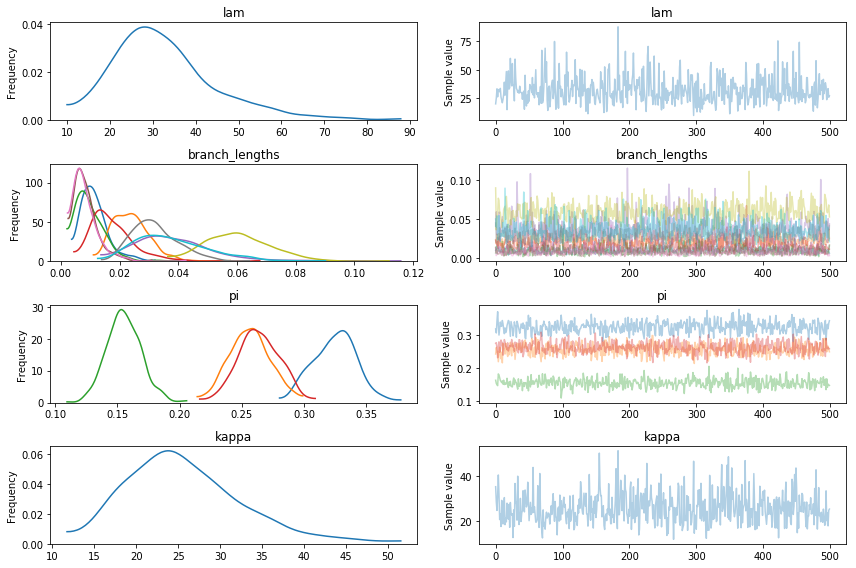

In [59]:
pm.traceplot(fit.sample())

In [64]:
with exponential_prior:
    trace = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/lib/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kappa_log__, pi_stickbreaking__, branch_lengths_log__, lam_log__]
100%|██████████| 2000/2000 [01:58<00:00, 16.86it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fae0f5908>,
      dtype=object)

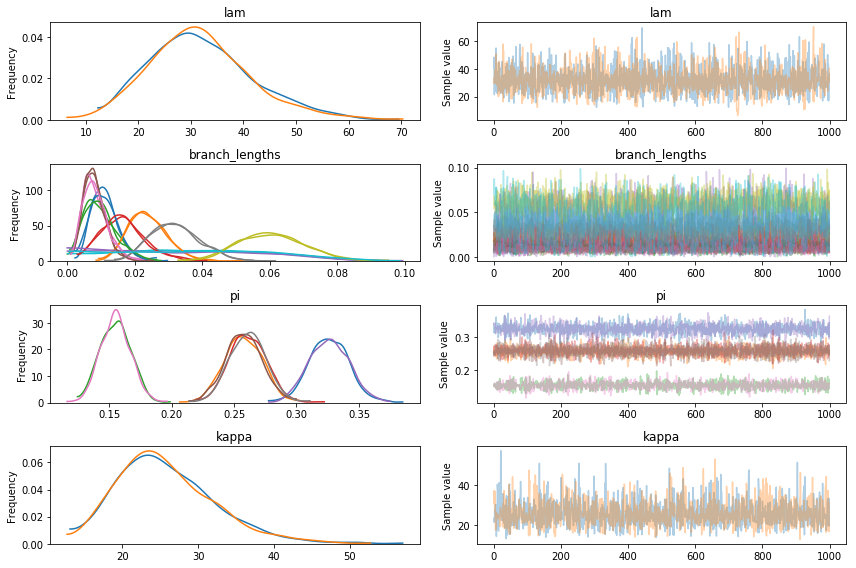

In [65]:
pm.traceplot(trace)